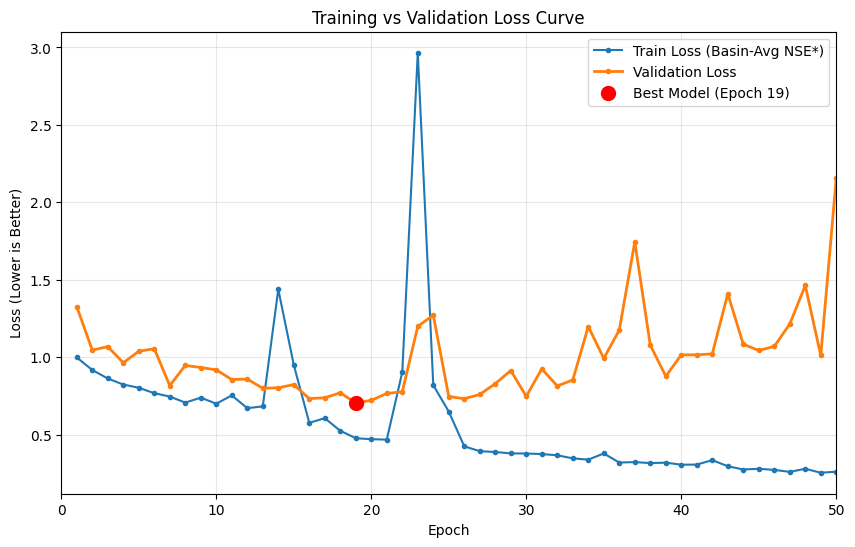

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from src.config import OUTPUT_DATA_DIR, PROCESSED_DATA_DIR

# --- 1. Parse the Log File ---
log_path = OUTPUT_DATA_DIR / "training_log.txt"

data = []
# Regex to find: "Epoch X/Y", "Train Loss ... : <val>", "Val Loss: <val>"
pattern = re.compile(r"Epoch (\d+)/\d+ \| Train Loss \(NSE\*\): ([\d\.]+) \| Val Loss: ([\d\.]+)")

with open(log_path, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            data.append({
                "epoch": int(match.group(1)),
                "train_loss": float(match.group(2)),
                "val_loss": float(match.group(3))
            })

df_logs = pd.DataFrame(data)

# --- 2. Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(df_logs["epoch"], df_logs["train_loss"], label="Train Loss (Basin-Avg NSE*)", marker='.')
plt.plot(df_logs["epoch"], df_logs["val_loss"], label="Validation Loss", marker='.', linewidth=2)

# Highlight the Minimum Validation Point (Best Model)
best_epoch = df_logs.loc[df_logs["val_loss"].idxmin()]
plt.scatter(best_epoch["epoch"], best_epoch["val_loss"], color='red', s=100, zorder=5, label=f"Best Model (Epoch {int(best_epoch['epoch'])})")

plt.xlabel("Epoch")
plt.ylabel("Loss (Lower is Better)")
plt.title("Training vs Validation Loss Curve")
plt.grid(True, alpha=0.3)
plt.xlim(0,50)
plt.legend()

plt.show()

In [8]:
import pandas as pd
import numpy as np
from src.config import OUTPUT_DATA_DIR, PROCESSED_DATA_DIR

# --- Helper Functions ---
def calculate_nse(obs, sim):
    """Computes Nash-Sutcliffe Efficiency. Returns NaN if not enough data."""
    mask = np.isfinite(obs) & np.isfinite(sim)
    obs_f = obs[mask]
    sim_f = sim[mask]
    
    if len(obs_f) < 10: return np.nan
        
    numerator = np.sum((obs_f - sim_f)**2)
    denominator = np.sum((obs_f - np.mean(obs_f))**2)
    
    return 1 - (numerator / denominator) if denominator != 0 else np.nan

print("⏳ Loading Data...")
# 1. Load Data
df_pred = pd.read_csv(OUTPUT_DATA_DIR / "test_set_predictions.csv", index_col=0, parse_dates=True)
df_flow_m3s = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)
df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)

# 2. Align Data
common_stations = df_pred.columns.intersection(df_flow_m3s.columns).intersection(df_static.index)
df_pred = df_pred[common_stations]
df_flow_m3s = df_flow_m3s.loc[df_pred.index, common_stations]

# 3. CONVERT OBSERVATIONS: m^3/s -> mm/day
# Formula: (Flow * 86.4) / Area_km2
print("   Converting observations from m3/s to mm/d...")
areas = df_static.loc[common_stations, 'basin_area_km2'].values
# Broadcasting the division across the columns
df_obs_mmd = (df_flow_m3s * 86.4) / areas

print(f"   Analyzing {len(common_stations)} stations...")

metrics_list = []
chunk1_mask = (df_pred.index.year >= 1980) & (df_pred.index.year <= 1989)
chunk2_mask = (df_pred.index.year >= 2013) & (df_pred.index.year <= 2022)

for station in common_stations:
    obs = df_obs_mmd[station].values
    sim = df_pred[station].values
    
    # Compute Metrics
    metrics_list.append({
        "station_id": station,
        "NSE_Total": calculate_nse(obs, sim),
        "NSE_1980_1989": calculate_nse(obs[chunk1_mask], sim[chunk1_mask]),
        "NSE_2013_2022": calculate_nse(obs[chunk2_mask], sim[chunk2_mask])
    })

df_metrics = pd.DataFrame(metrics_list)
output_path = OUTPUT_DATA_DIR / "nse_metrics_summary.csv"
df_metrics.to_csv(output_path, index=False)
print(f"✅ Metrics (calculated in mm/d) saved to {output_path}")

⏳ Loading Data...
   Converting observations from m3/s to mm/d...
   Analyzing 132 stations...
✅ Metrics (calculated in mm/d) saved to C:\Users\tbwil\Documents\School\MSc Geophysics\Thesis Project\data\output\nse_metrics_summary.csv


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from ipywidgets import interact, Dropdown, fixed
from src.config import OUTPUT_DATA_DIR, PROCESSED_DATA_DIR

# --- Load Data Once ---
print("⏳ Loading Data for Plotting...")
if 'df_pred' not in locals():
    df_pred = pd.read_csv(OUTPUT_DATA_DIR / "test_set_predictions.csv", index_col=0, parse_dates=True)
    df_flow_m3s = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)
    df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)

    # Pre-convert observations globally for speed
    common_cols = df_pred.columns.intersection(df_flow_m3s.columns)
    areas = df_static.loc[common_cols, 'basin_area_km2']
    
    # Create the dataframe in mm/day
    df_obs_mmd = (df_flow_m3s[common_cols] * 86.4) / areas

def plot_hydrograph(station_id, year, df_pred, df_obs_mmd):
    """Plots Observed vs Predicted in mm/day."""
    if station_id not in df_pred.columns or station_id not in df_obs_mmd.columns:
        print(f"❌ Station {station_id} missing.")
        return

    try:
        pred_slice = df_pred.loc[f"{year}", station_id]
        obs_slice = df_obs_mmd.loc[f"{year}", station_id]
    except KeyError:
        print(f"No data for {year}")
        return

    # Calculate NSE for Title
    mask = np.isfinite(obs_slice.values) & np.isfinite(pred_slice.values)
    valid_obs = obs_slice.values[mask]
    valid_pred = pred_slice.values[mask]
    
    title_nse = "NSE: N/A"
    if len(valid_obs) > 10:
        num = np.sum((valid_obs - valid_pred)**2)
        den = np.sum((valid_obs - np.mean(valid_obs))**2)
        nse = 1 - (num/den) if den != 0 else np.nan
        title_nse = f"NSE: {nse:.3f}"

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(obs_slice.index, obs_slice.values, color='black', alpha=0.6, label='Observed (mm/d)')
    plt.plot(pred_slice.index, pred_slice.values, color='#1f77b4', linestyle='--', label='Predicted (mm/d)')
    
    plt.title(f"Station {station_id} - {year} | {title_nse}")
    plt.ylabel("Specific Runoff (mm/d)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.show()

# --- Interactive Widget ---
stations = sorted(list(df_pred.columns))
years = sorted(list(df_pred.index.year.unique()))

interact(
    plot_hydrograph, 
    station_id=Dropdown(options=stations, description='Station:'), 
    year=Dropdown(options=years, description='Year:', value=2015),
    df_pred=fixed(df_pred),
    df_obs_mmd=fixed(df_obs_mmd) # Pass the converted dataframe
);

⏳ Loading Data for Plotting...


interactive(children=(Dropdown(description='Station:', options=('05AA004', '05AA008', '05AA022', '05AA027', '0…

⏳ Loading Data...
⚙️ Computing Regime Curves (mm/d)...
🔢 Clustering...


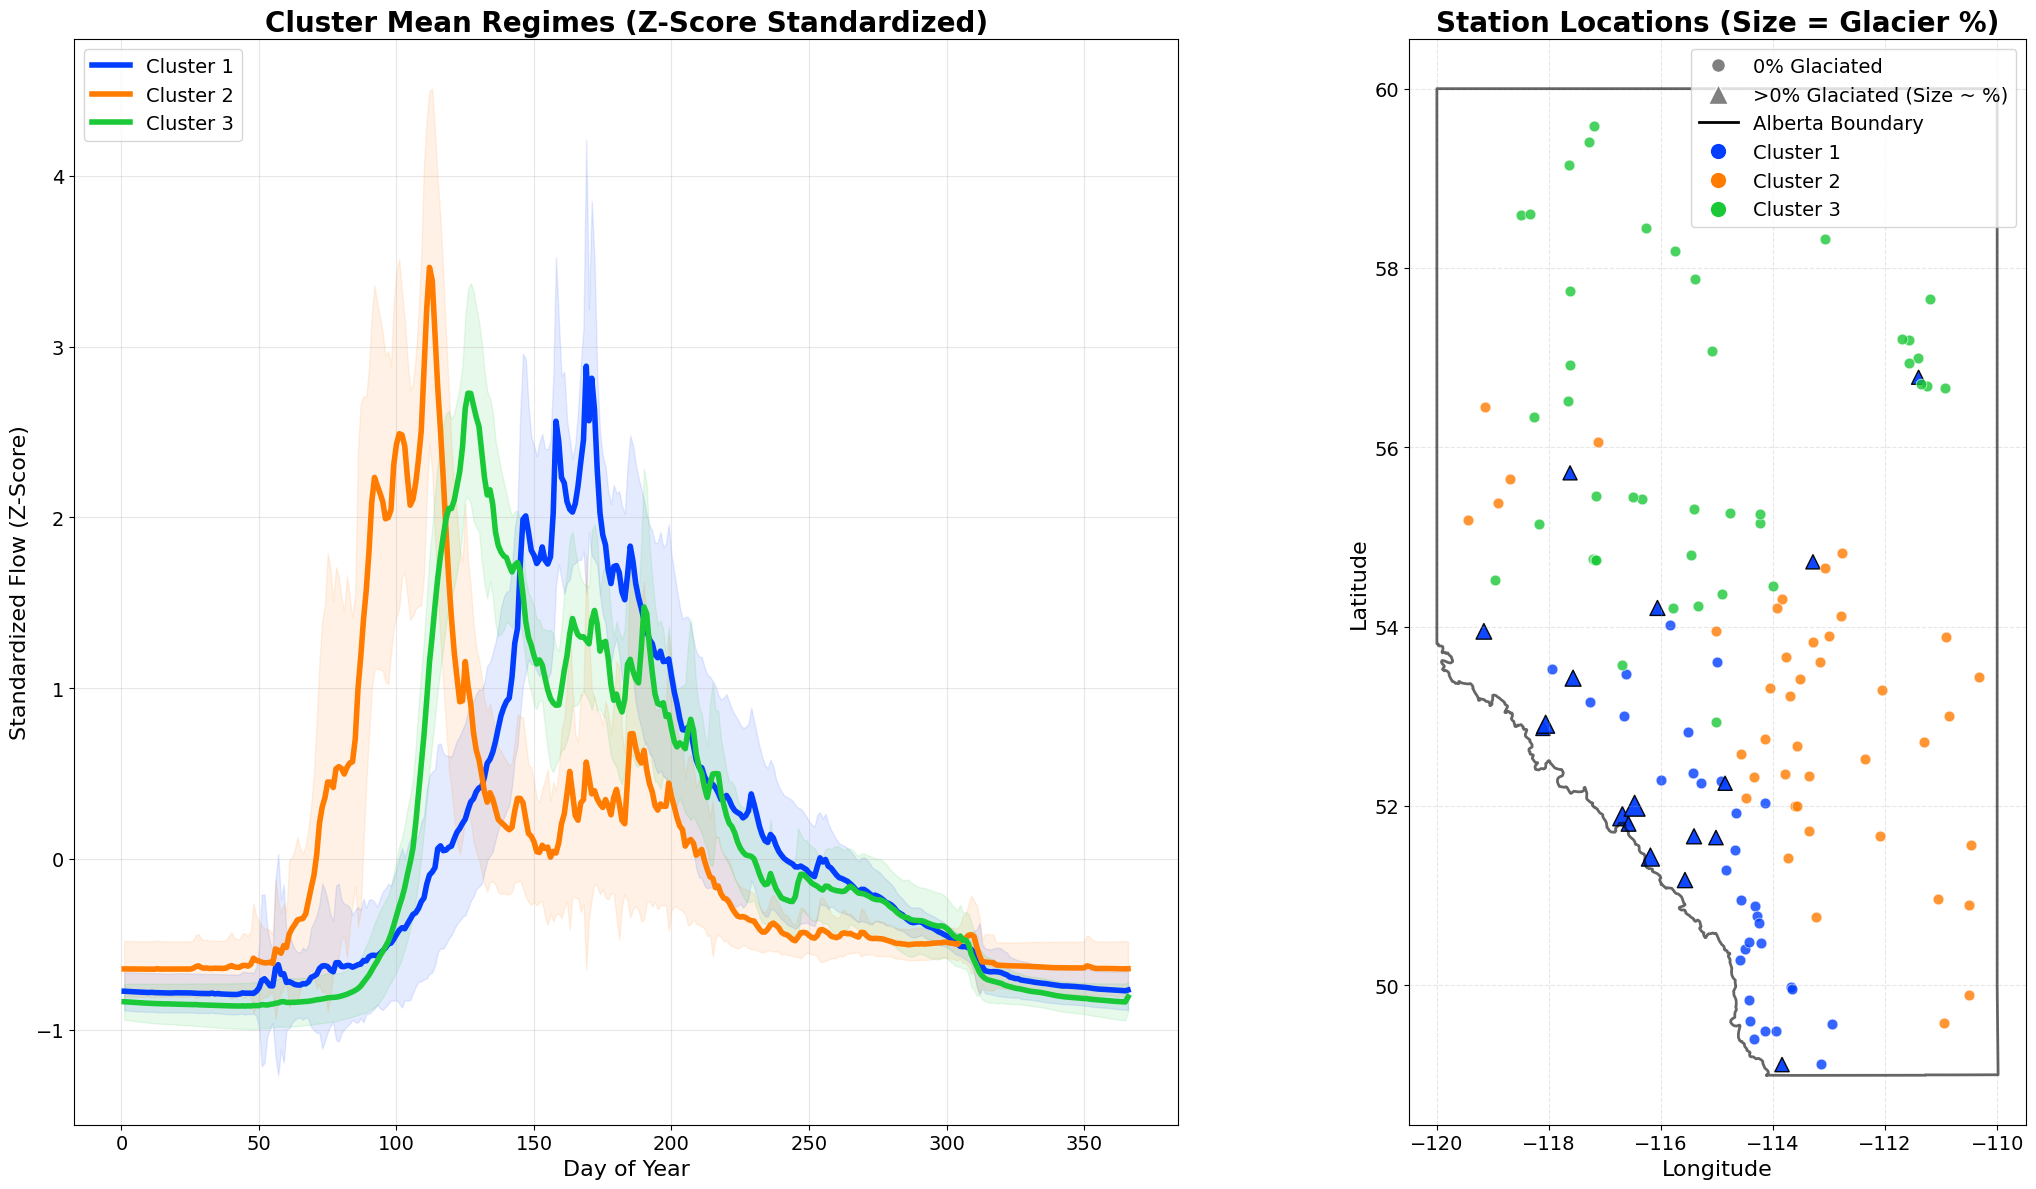

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

# --- 1. Load Data ---
print("⏳ Loading Data...")
df_flow = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)
df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)
df_meta = pd.read_csv(RAW_DATA_DIR / "station_metadata.csv")

# Ensure alignment
common_stations = df_flow.columns.intersection(df_static.index)
df_flow = df_flow[common_stations]
df_static = df_static.loc[common_stations]

# --- 2. Process Flow Data ---
print("⚙️ Computing Regime Curves (mm/d)...")
areas = df_static['basin_area_km2']
df_spec = (df_flow * 86.4) / areas

df_spec['doy'] = df_spec.index.dayofyear
regimes = df_spec.groupby('doy').mean().T

# Impute Missing Days
for station in regimes.index:
    if regimes.loc[station].isnull().any():
        regimes.loc[station] = regimes.loc[station].fillna(regimes.loc[station].min())

# --- 3. Clustering (Z-Score) ---
print("🔢 Clustering...")
scaler = StandardScaler()
regimes_norm = scaler.fit_transform(regimes.T).T 
df_norm = pd.DataFrame(regimes_norm, index=regimes.index, columns=regimes.columns)

K = 3
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_norm)

# --- 4. Prepare Plot Data ---
id_col = 'ID' if 'ID' in df_meta.columns else df_meta.columns[0]
df_meta[id_col] = df_meta[id_col].astype(str)

df_map = pd.DataFrame({"Cluster": labels}, index=regimes.index)
df_map = df_map.join(df_meta.set_index(id_col)[['Latitude', 'Longitude']], how='inner')
df_map = df_map.join(df_static['glacier_pct'], how='inner')

# --- 5. Visualization ---
# Increased figure size for clarity
fig = plt.figure(figsize=(24, 12))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2])
colors = sns.color_palette("bright", K)

# --- Plot A: Hydrographs ---
ax1 = fig.add_subplot(gs[0])
for k in range(K):
    stations = df_map[df_map["Cluster"] == k].index
    curve_mean = df_norm.loc[stations].mean(axis=0)
    ax1.plot(curve_mean.index, curve_mean.values, color=colors[k], linewidth=4, label=f'Cluster {k+1}')
    
    curve_std = df_norm.loc[stations].std(axis=0)
    ax1.fill_between(curve_mean.index, curve_mean - curve_std, curve_mean + curve_std, color=colors[k], alpha=0.1)

# Larger Fonts
ax1.set_title("Cluster Mean Regimes (Z-Score Standardized)", fontsize=20, weight='bold')
ax1.set_ylabel("Standardized Flow (Z-Score)", fontsize=16)
ax1.set_xlabel("Day of Year", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(loc="upper left", fontsize=14)
ax1.grid(True, alpha=0.3)

# --- Plot B: Map ---
ax2 = fig.add_subplot(gs[1])

# 1. Plot Boundary
try:
    boundary_dir = RAW_DATA_DIR / "AB_boundary"
    ab_lat = pd.read_csv(boundary_dir / "ABlat.csv", header=None).values.flatten()
    ab_lon = pd.read_csv(boundary_dir / "ABlon.csv", header=None).values.flatten()
    ax2.plot(ab_lon, ab_lat, 'k-', linewidth=2, alpha=0.6, label="Alberta Boundary")
except Exception as e:
    print(f"⚠️ Could not load boundary files: {e}")

# 2. Plot Stations by Cluster
for k in range(K):
    cluster_data = df_map[df_map["Cluster"] == k]
    
    # Split Data
    non_glaciated = cluster_data[cluster_data['glacier_pct'] <= 0]
    glaciated = cluster_data[cluster_data['glacier_pct'] > 0]
    
    # Plot Non-Glaciated
    if not non_glaciated.empty:
        ax2.scatter(
            non_glaciated['Longitude'], non_glaciated['Latitude'], 
            color=colors[k], marker='o', s=60, alpha=0.8, edgecolor='white', linewidth=0.5
        )
        
    # Plot Glaciated (Larger Sizes)
    if not glaciated.empty:
        # Scale size up for visibility
        sizes = 100 + (glaciated['glacier_pct'] * 10)
        ax2.scatter(
            glaciated['Longitude'], glaciated['Latitude'], 
            color=colors[k], marker='^', s=sizes, alpha=0.95, edgecolor='black', linewidth=1
        )

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='0% Glaciated'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=14, label='>0% Glaciated (Size ~ %)'),
    Line2D([0], [0], color='black', lw=2, label='Alberta Boundary')
]
for k in range(K):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[k], markersize=12, label=f'Cluster {k+1}'))

ax2.legend(handles=legend_elements, loc="upper right", fontsize=14, frameon=True)

# Larger Fonts & Aspect Ratio Fix
ax2.set_title("Station Locations (Size = Glacier %)", fontsize=20, weight='bold')
ax2.set_xlabel("Longitude", fontsize=16)
ax2.set_ylabel("Latitude", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid(True, linestyle='--', alpha=0.3)

# FIX THE SKEW: Set Aspect Ratio
# 1.6 is roughly 1/cos(51 degrees), appropriate for AB/BC latitudes
ax2.set_aspect(1.6)

plt.tight_layout()
plt.show()

⏳ Loading Datasets...
⚙️ Computing Clusters...
⚙️ Computing Attributes...


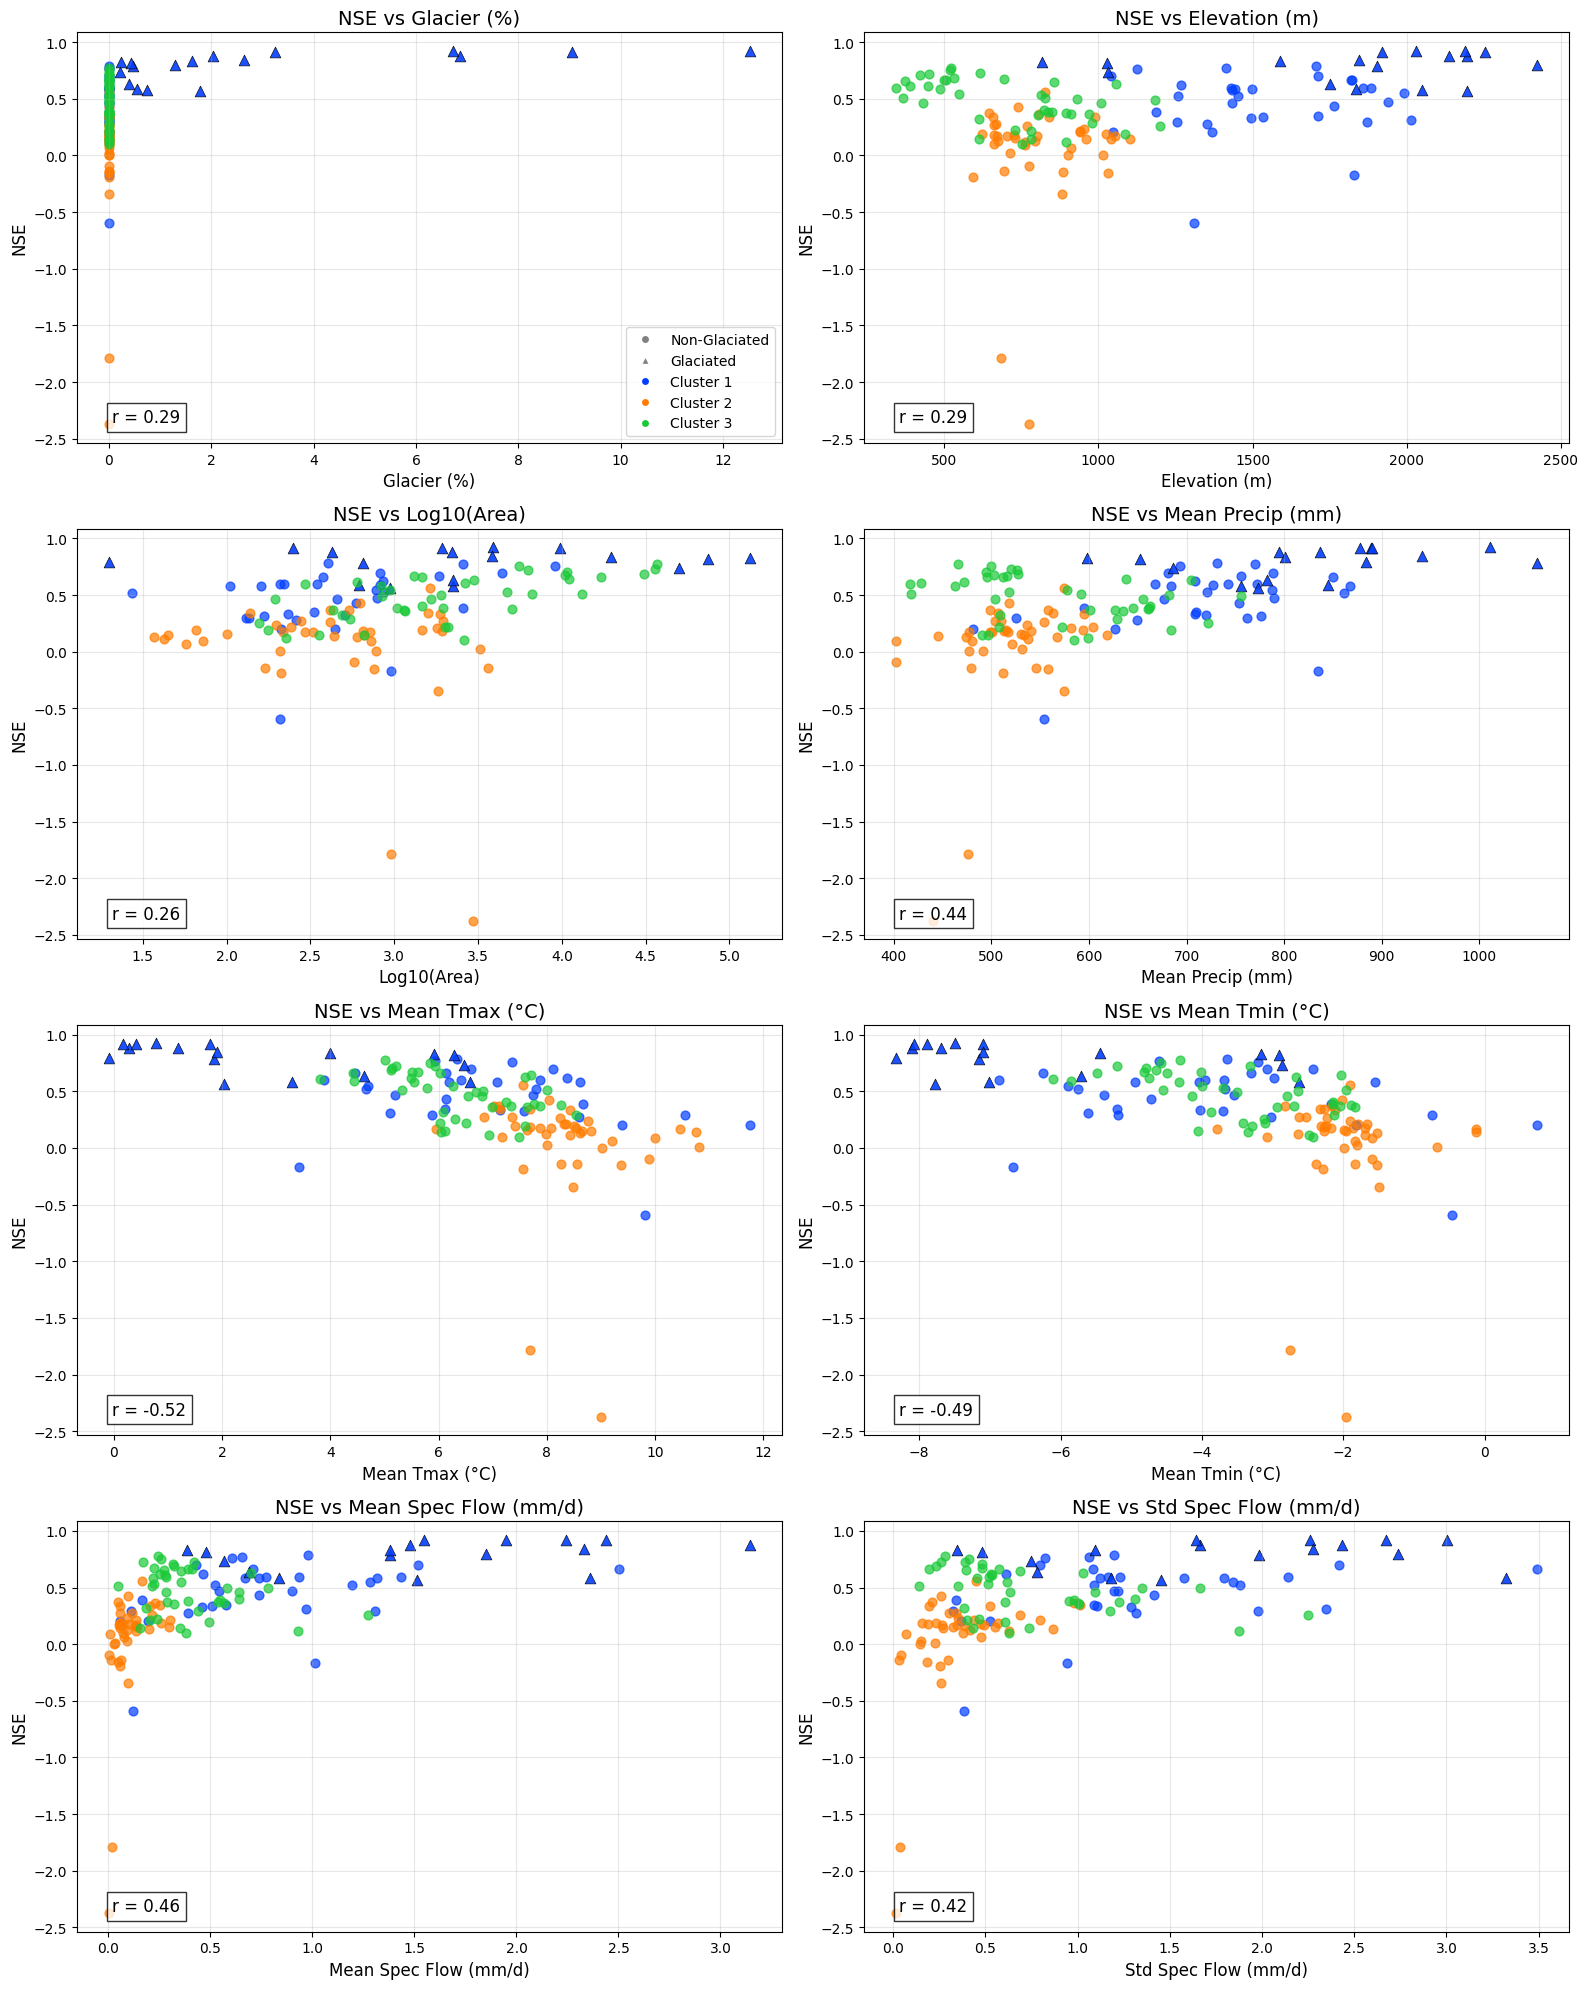

C:\Users\tbwil\AppData\Local\Temp\ipykernel_29896\2899872187.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="Cluster", y="NSE", palette="bright", width=0.5)


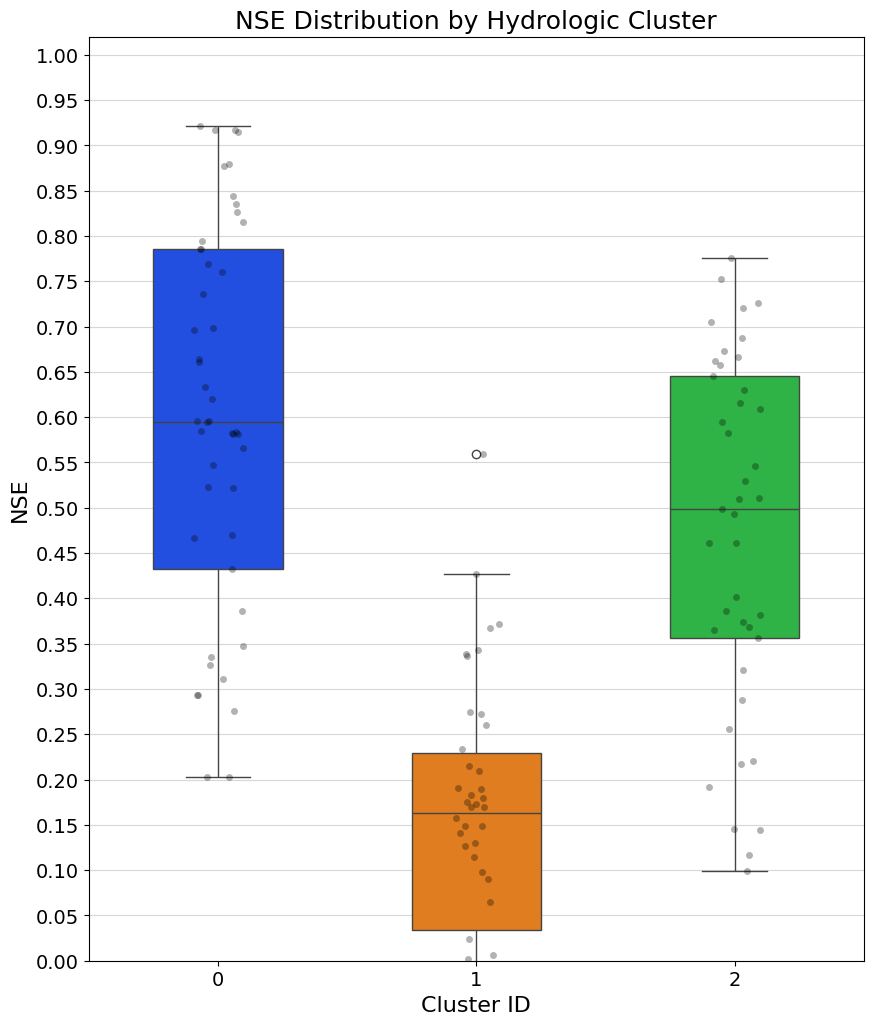

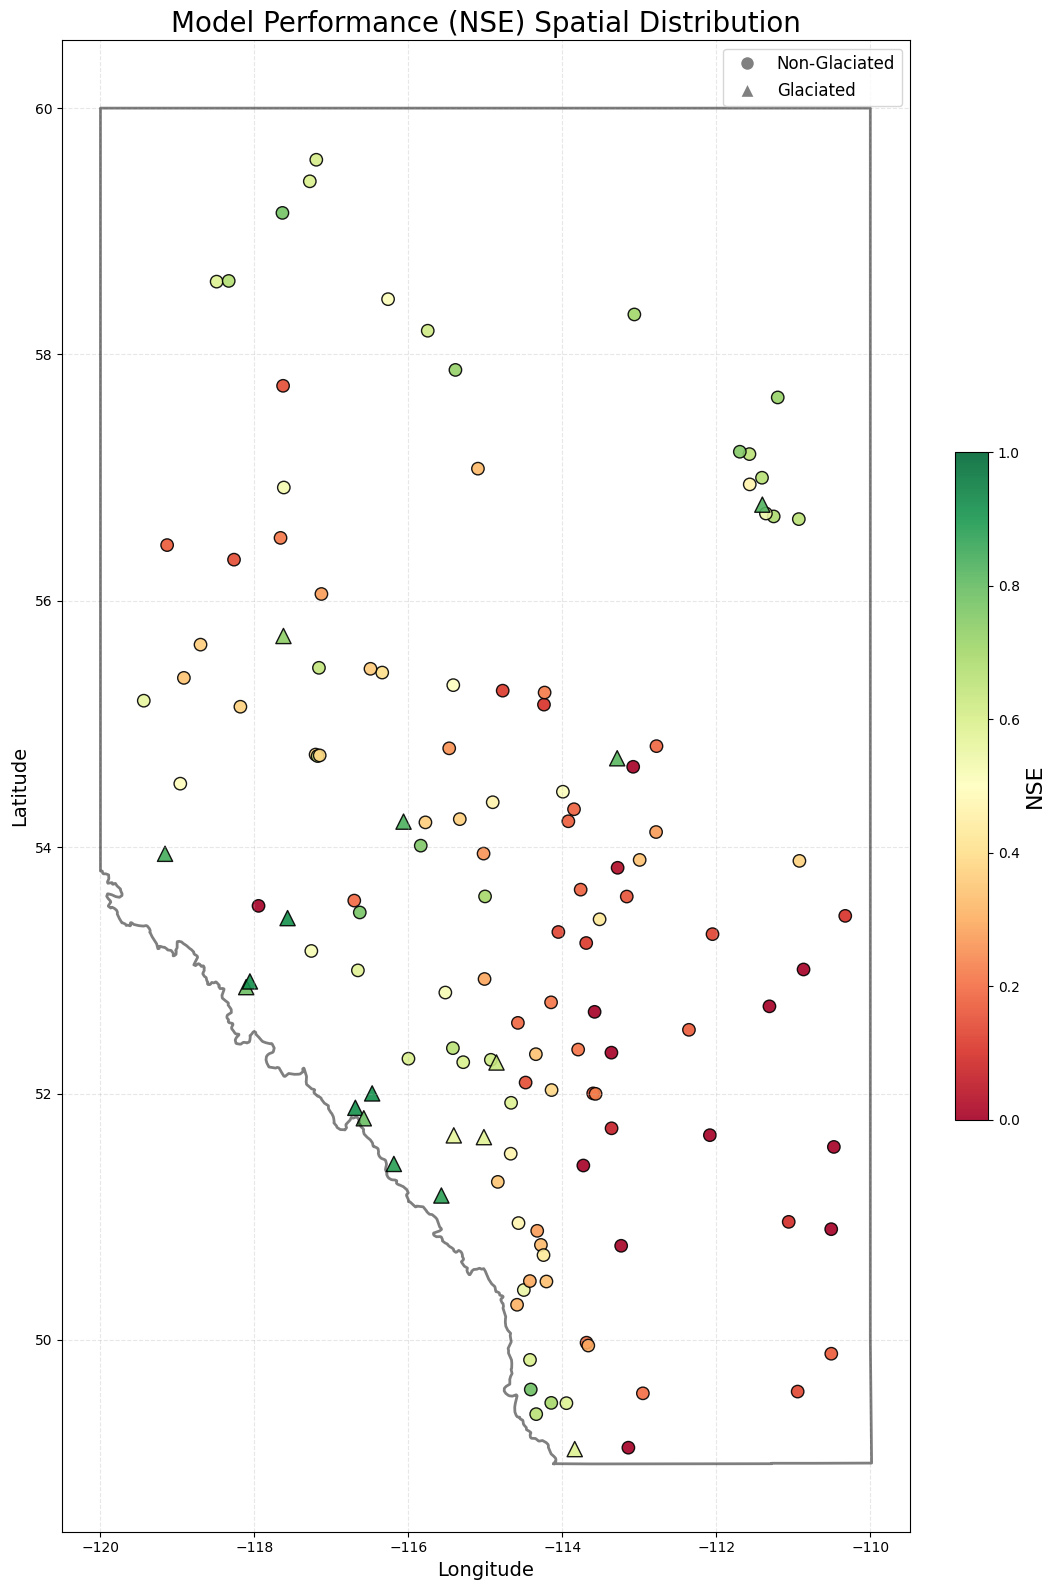

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, OUTPUT_DATA_DIR, CLIMATE_OUTPUT_DIR

# --- 1. Load All Data ---
print("⏳ Loading Datasets...")
df_flow = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)
df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)
df_metrics = pd.read_csv(OUTPUT_DATA_DIR / "nse_metrics_summary.csv", index_col=0)
df_meta = pd.read_csv(RAW_DATA_DIR / "station_metadata.csv")

# Load Climate Data
df_precip = pd.read_csv(CLIMATE_OUTPUT_DIR / "daily_precipitation.csv", index_col=0, parse_dates=True)
df_tmax = pd.read_csv(CLIMATE_OUTPUT_DIR / "daily_temp_max.csv", index_col=0, parse_dates=True)
df_tmin = pd.read_csv(CLIMATE_OUTPUT_DIR / "daily_temp_min.csv", index_col=0, parse_dates=True)

# Align all data to common stations and time range (1980-2022)
common_stations = df_flow.columns.intersection(df_static.index).intersection(df_metrics.index)
start_date, end_date = "1980-01-01", "2022-12-31"

df_flow = df_flow.loc[start_date:end_date, common_stations]
df_static = df_static.loc[common_stations]
df_metrics = df_metrics.loc[common_stations]
df_precip = df_precip.loc[start_date:end_date, common_stations]
df_tmax = df_tmax.loc[start_date:end_date, common_stations]
df_tmin = df_tmin.loc[start_date:end_date, common_stations]

# --- 2. Perform Clustering ---
print("⚙️ Computing Clusters...")
areas = df_static['basin_area_km2']
df_spec = (df_flow * 86.4) / areas

df_spec['doy'] = df_spec.index.dayofyear
regimes = df_spec.groupby('doy').mean().T
for stn in regimes.index:
    regimes.loc[stn] = regimes.loc[stn].fillna(regimes.loc[stn].min())

scaler = StandardScaler()
regimes_norm = scaler.fit_transform(regimes.T).T 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(regimes_norm)
df_clusters = pd.Series(labels, index=regimes.index, name="Cluster")

# --- 3. Compute Plotting Attributes ---
print("⚙️ Computing Attributes...")
plot_data = []

for station in common_stations:
    area = df_static.loc[station, 'basin_area_km2']
    glacier = df_static.loc[station, 'glacier_pct']
    
    q_mmd = (df_flow[station] * 86.4) / area
    
    plot_data.append({
        "station_id": station,
        "NSE": df_metrics.loc[station, "NSE_Total"],
        "Cluster": df_clusters.loc[station],
        "Glacier (%)": glacier,
        "Elevation (m)": df_static.loc[station, 'mean_elev'],
        "Log10(Area)": np.log10(area),
        "Mean Precip (mm)": df_precip[station].mean() * 365,
        "Mean Tmax (°C)": df_tmax[station].mean(),
        "Mean Tmin (°C)": df_tmin[station].mean(),
        "Mean Spec Flow (mm/d)": q_mmd.mean(),
        "Std Spec Flow (mm/d)": q_mmd.std(),
        "is_glaciated": glacier > 0
    })

df_plot = pd.DataFrame(plot_data).set_index("station_id")

id_col = 'ID' if 'ID' in df_meta.columns else df_meta.columns[0]
df_meta[id_col] = df_meta[id_col].astype(str)
df_plot = df_plot.join(df_meta.set_index(id_col)[['Latitude', 'Longitude']], how='inner')

# --- 4. Plot 1: Grid of Scatter Plots ---
attributes = [
    "Glacier (%)", "Elevation (m)", "Log10(Area)", "Mean Precip (mm)",
    "Mean Tmax (°C)", "Mean Tmin (°C)", "Mean Spec Flow (mm/d)", "Std Spec Flow (mm/d)"
]

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()
colors = sns.color_palette("bright", 3)

for i, attr in enumerate(attributes):
    ax = axes[i]
    for k in range(3):
        subset = df_plot[df_plot["Cluster"] == k]
        
        non_glac = subset[~subset["is_glaciated"]]
        ax.scatter(non_glac[attr], non_glac["NSE"], c=[colors[k]], marker='o', s=40, alpha=0.7)
        
        glac = subset[subset["is_glaciated"]]
        ax.scatter(glac[attr], glac["NSE"], c=[colors[k]], marker='^', s=60, alpha=0.9, edgecolor='k', linewidth=0.5)

    ax.set_xlabel(attr, fontsize=12)
    ax.set_ylabel("NSE", fontsize=12)
    ax.set_title(f"NSE vs {attr}", fontsize=14)
    ax.grid(True, alpha=0.3)
    
    corr = df_plot[[attr, "NSE"]].corr().iloc[0,1]
    ax.text(0.05, 0.05, f"r = {corr:.2f}", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', label='Non-Glaciated'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', label='Glaciated'),
] + [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[k], label=f'Cluster {k+1}') for k in range(3)]
axes[0].legend(handles=handles, loc='best')

plt.tight_layout()
plt.show()

# --- 5. Plot 2: Taller Boxplot ---
# Adjusted figsize to (10, 12) for better vertical resolution
plt.figure(figsize=(10, 12)) 

sns.boxplot(data=df_plot, x="Cluster", y="NSE", palette="bright", width=0.5)
sns.stripplot(data=df_plot, x="Cluster", y="NSE", color='black', alpha=0.3, jitter=True)

plt.title("NSE Distribution by Hydrologic Cluster", fontsize=18)
plt.xlabel("Cluster ID", fontsize=16)
plt.ylabel("NSE", fontsize=16)
plt.yticks(np.arange(0, 1.05, 0.05)) # Granular ticks every 0.05
plt.ylim(0, 1.02) # Force focus on the 0-1 range
plt.grid(True, axis='y', alpha=0.5)
plt.tick_params(labelsize=14)
plt.show()

# --- 6. Plot 3: Spatial Heatmap with Shapes ---
fig, ax = plt.subplots(figsize=(12, 16))

try:
    boundary_dir = RAW_DATA_DIR / "AB_boundary"
    ab_lat = pd.read_csv(boundary_dir / "ABlat.csv", header=None).values.flatten()
    ab_lon = pd.read_csv(boundary_dir / "ABlon.csv", header=None).values.flatten()
    ax.plot(ab_lon, ab_lat, 'k-', linewidth=2, alpha=0.5, label="Alberta Boundary")
except:
    pass

# Plot Non-Glaciated (Circles)
non_glac = df_plot[~df_plot["is_glaciated"]]
sc = ax.scatter(
    non_glac["Longitude"], non_glac["Latitude"],
    c=non_glac["NSE"], cmap="RdYlGn", vmin=0, vmax=1,
    marker='o', s=80, edgecolor='k', alpha=0.9, label="Non-Glaciated"
)

# Plot Glaciated (Triangles)
glac = df_plot[df_plot["is_glaciated"]]
ax.scatter(
    glac["Longitude"], glac["Latitude"],
    c=glac["NSE"], cmap="RdYlGn", vmin=0, vmax=1,
    marker='^', s=120, edgecolor='k', alpha=0.9, label="Glaciated (>0%)"
)

cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("NSE", fontsize=16)

# Legend for Shapes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Non-Glaciated'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=10, label='Glaciated')
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=12)

ax.set_title("Model Performance (NSE) Spatial Distribution", fontsize=20)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_aspect(1.6)
ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

⏳ Loading Data...
⚙️ Computing Clusters...
⚙️ Calculating Yearly & Monthly Statistics...
✅ Processed 2640 yearly records.


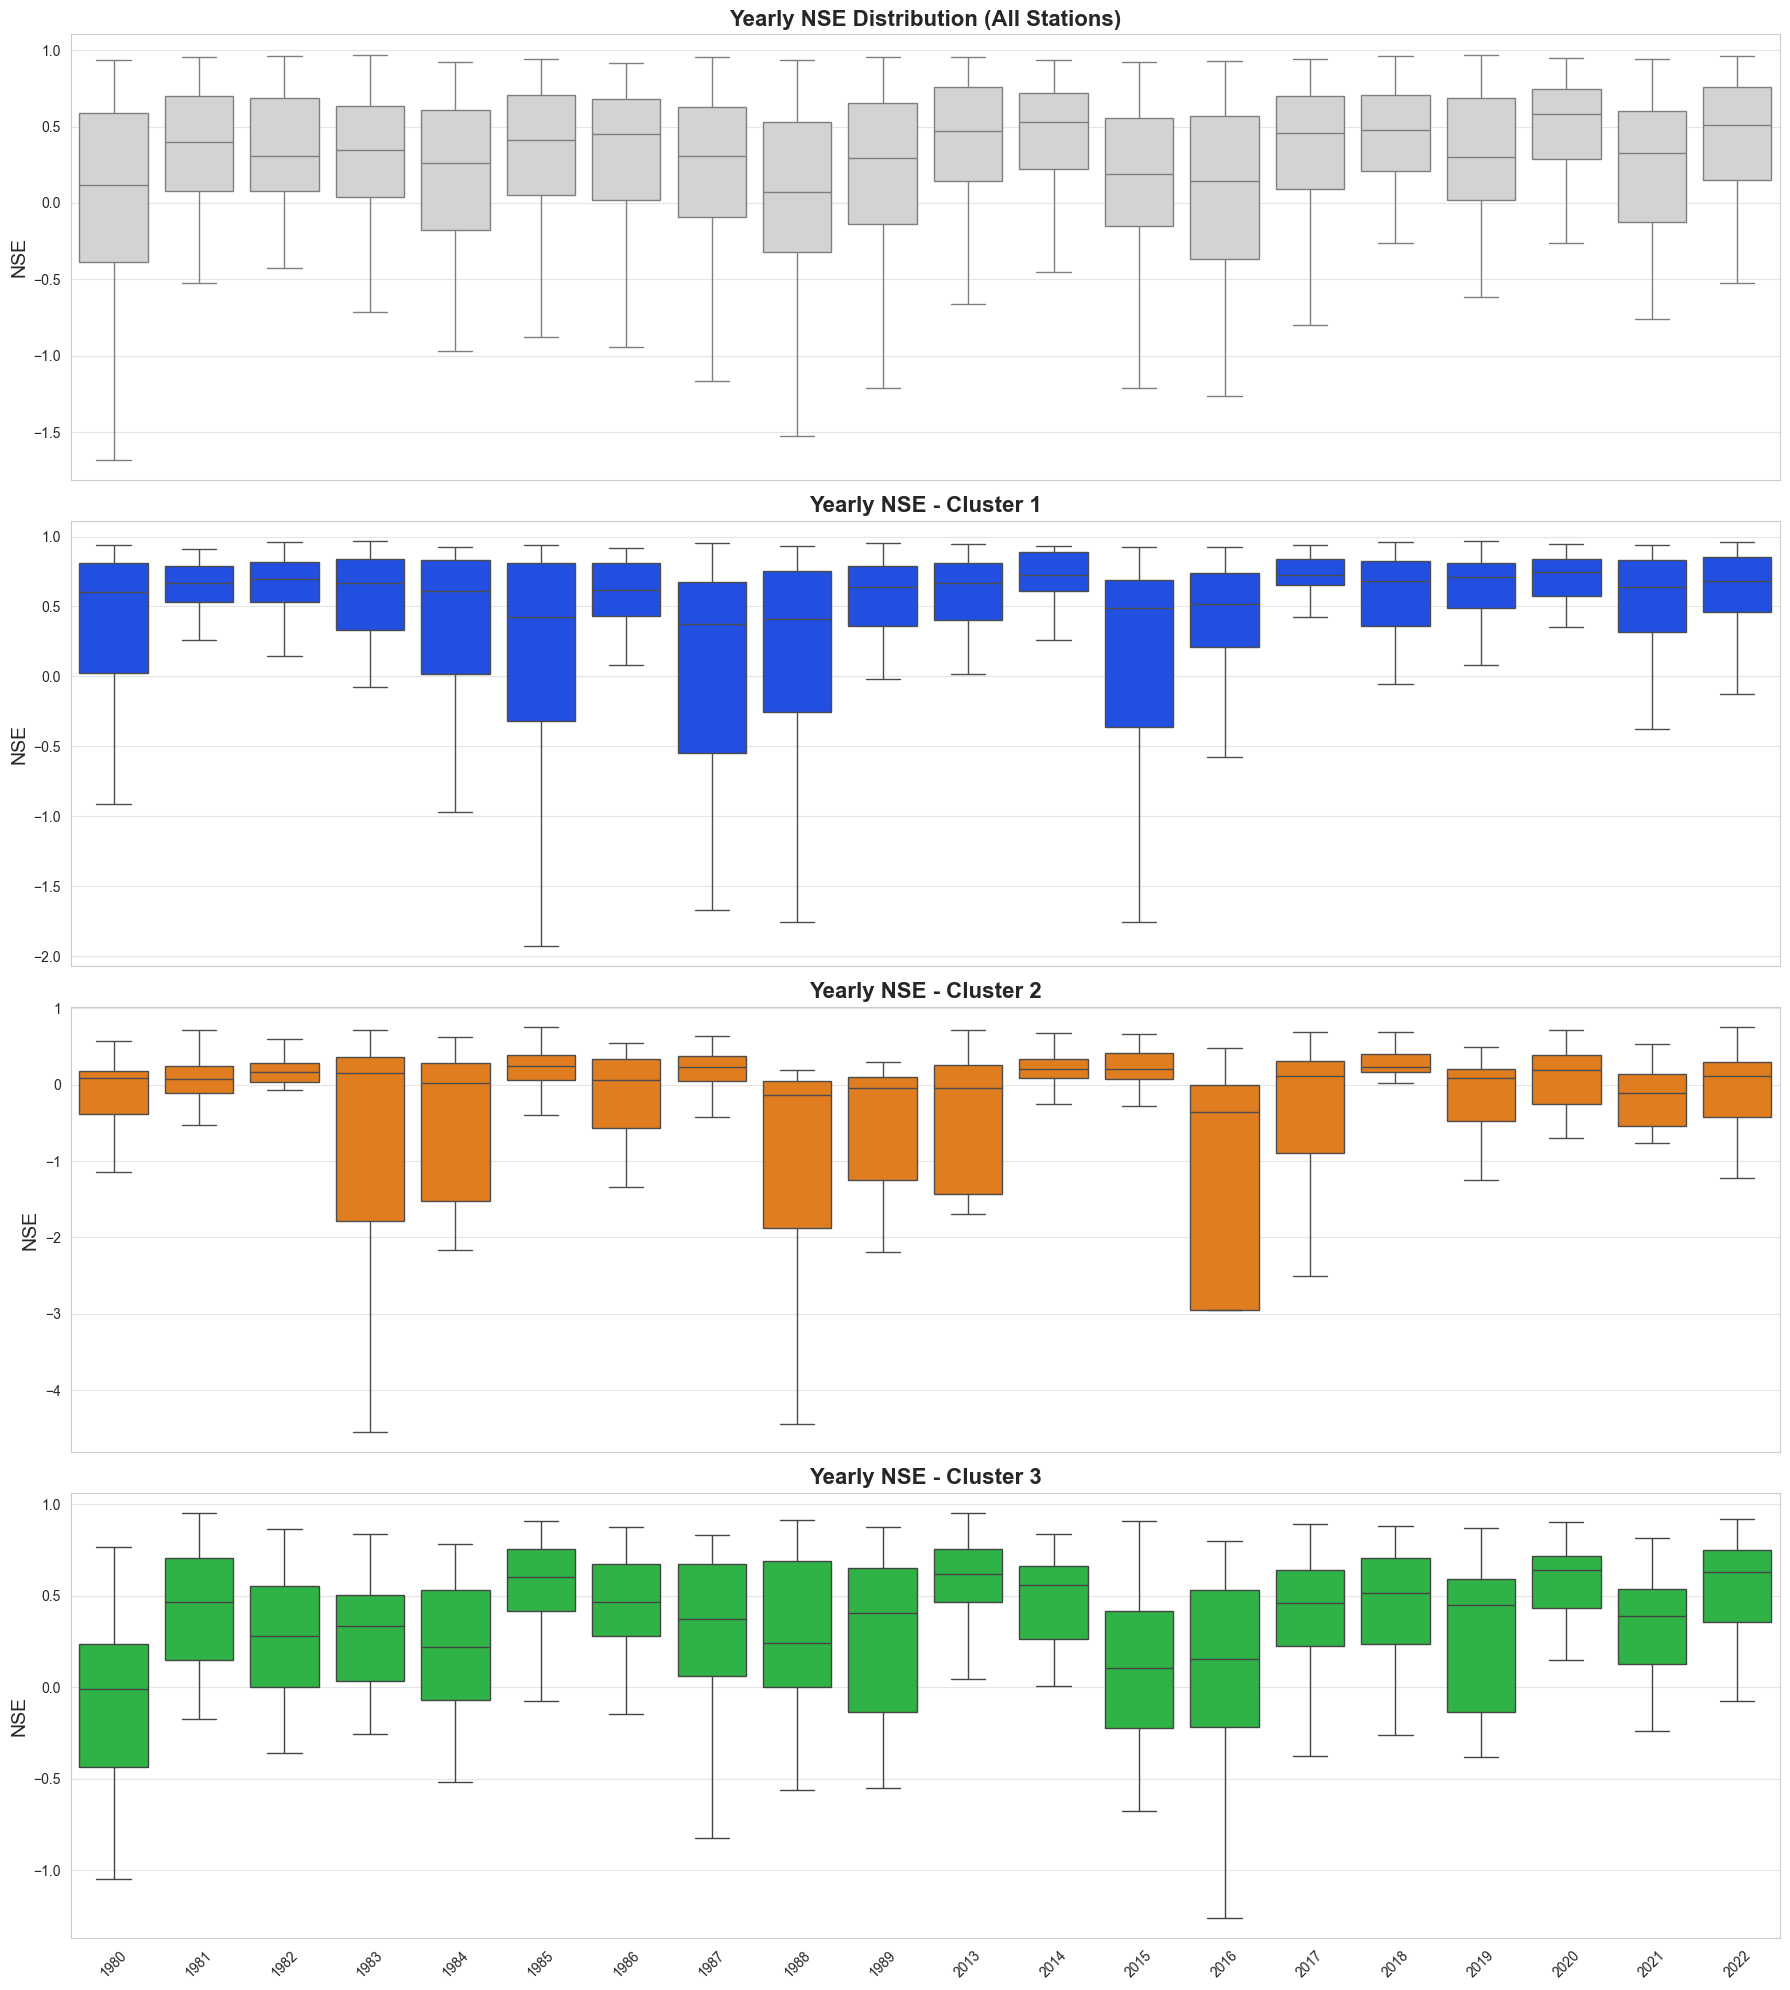

C:\Users\tbwil\AppData\Local\Temp\ipykernel_29896\307463406.py:143: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(month_labels)
C:\Users\tbwil\AppData\Local\Temp\ipykernel_29896\307463406.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(month_labels)
C:\Users\tbwil\AppData\Local\Temp\ipykernel_29896\307463406.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(month_labels)
C:\Users\tbwil\AppData\Local\Temp\ipykernel_29896\307463406.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(month_labels)


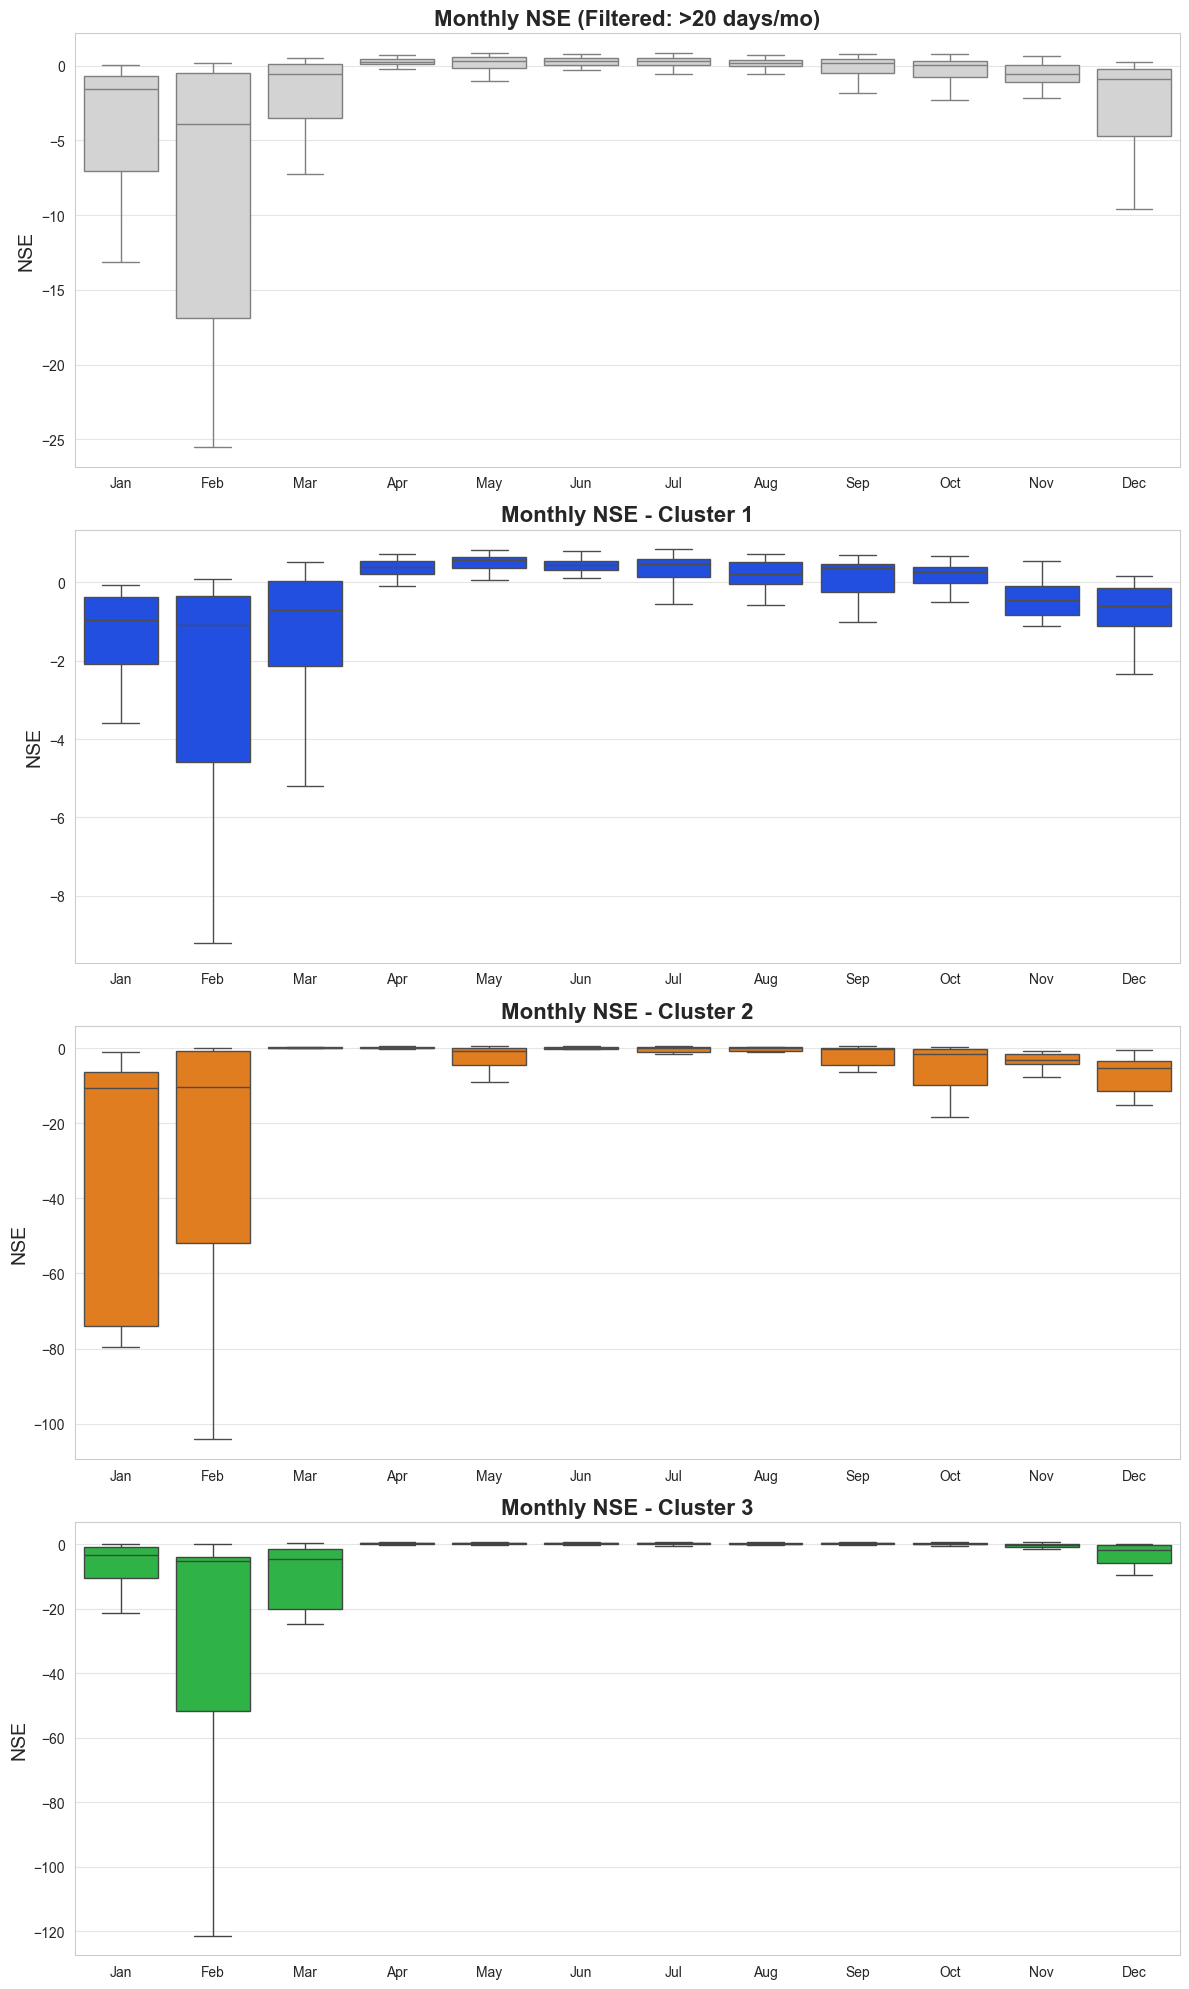


📊 Cluster Performance Summary (Median NSE):
----------------------------------------
Cluster    | Yearly Median   | Best Month   | Worst Month 
----------------------------------------
Cluster 1  | 0.655           | May          | Feb         
Cluster 2  | 0.107           | Mar          | Jan         
Cluster 3  | 0.450           | May          | Feb         


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from src.config import PROCESSED_DATA_DIR, OUTPUT_DATA_DIR

# --- 1. Load & Align Data ---
print("⏳ Loading Data...")
df_flow = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)
df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)
df_pred = pd.read_csv(OUTPUT_DATA_DIR / "test_set_predictions.csv", index_col=0, parse_dates=True)

# Common Range & Stations
common_stations = df_flow.columns.intersection(df_static.index).intersection(df_pred.columns)
start_date, end_date = "1980-01-01", "2022-12-31"

df_flow = df_flow.loc[start_date:end_date, common_stations]
df_pred = df_pred.loc[start_date:end_date, common_stations]
df_static = df_static.loc[common_stations]

# Convert Obs to mm/d
areas = df_static['basin_area_km2']
df_obs_mmd = (df_flow * 86.4) / areas

# --- 2. Re-Compute Clusters ---
print("⚙️ Computing Clusters...")
df_regime = df_obs_mmd.copy()
df_regime['doy'] = df_regime.index.dayofyear
regimes = df_regime.groupby('doy').mean().T
for stn in regimes.index:
    regimes.loc[stn] = regimes.loc[stn].fillna(regimes.loc[stn].min())

scaler = StandardScaler()
regimes_norm = scaler.fit_transform(regimes.T).T 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(regimes_norm)
cluster_map = pd.Series(labels, index=regimes.index, name="Cluster")

# --- 3. Calculate NSE Metrics ---
def get_nse(obs, sim):
    """Robust NSE calculation ignoring NaNs."""
    mask = np.isfinite(obs) & np.isfinite(sim)
    o, s = obs[mask], sim[mask]
    # Check if we have enough data total (after filtering sparse months)
    if len(o) < 20: return np.nan
    num = np.sum((o - s)**2)
    den = np.sum((o - np.mean(o))**2)
    return 1 - (num / den) if den != 0 else np.nan

print("⚙️ Calculating Yearly & Monthly Statistics...")

yearly_data = []
monthly_data = []

for station in common_stations:
    cluster = cluster_map.loc[station]
    
    # A. Align Data
    aligned = pd.concat([df_obs_mmd[station], df_pred[station]], axis=1, join='inner')
    aligned.columns = ["obs", "sim"]
    
    s_obs = aligned["obs"]
    s_sim = aligned["sim"]
    
    # B. Yearly NSE (Standard Logic)
    years = s_sim.index.year.unique()
    for yr in years:
        mask_yr = (s_sim.index.year == yr)
        # For Yearly, we assume if you have the year, we calculate it
        # (You could apply a similar >300 days filter here if desired)
        nse = get_nse(s_obs[mask_yr].values, s_sim[mask_yr].values)
        
        yearly_data.append({
            "Station": station,
            "Cluster": cluster,
            "Year": yr,
            "NSE": nse
        })

    # C. Monthly NSE (With Sparse Month Filter)
    # 1. Identify valid months: Count valid days per (Year, Month)
    #    transform('count') returns a series of the same length as the index
    counts = aligned.groupby([aligned.index.year, aligned.index.month])['obs'].transform('count')
    
    # 2. Filter: Only keep rows where that specific month-year had >= 20 days
    aligned_clean = aligned[counts >= 20]
    
    s_obs_clean = aligned_clean["obs"]
    s_sim_clean = aligned_clean["sim"]

    for m in range(1, 13):
        # Select all "Clean" Januaries, Februaries, etc.
        mask_m = (s_sim_clean.index.month == m)
        
        # Calculate NSE on the aggregated clean data
        nse = get_nse(s_obs_clean[mask_m].values, s_sim_clean[mask_m].values)
        
        monthly_data.append({
            "Station": station,
            "Cluster": cluster,
            "Month": m,
            "NSE": nse
        })

df_yearly = pd.DataFrame(yearly_data)
df_monthly = pd.DataFrame(monthly_data)

print(f"✅ Processed {len(df_yearly)} yearly records.")

# --- 4. Plotting Configuration ---
sns.set_style("whitegrid")
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
colors = sns.color_palette("bright", 3)

def style_boxplot(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True, axis='y', alpha=0.5)

# --- PLOT 1: Yearly NSE ---
fig, axes = plt.subplots(4, 1, figsize=(18, 20), sharex=True)

sns.boxplot(data=df_yearly, x="Year", y="NSE", ax=axes[0], color='lightgrey', showfliers=False)
style_boxplot(axes[0], "Yearly NSE Distribution (All Stations)", "", "NSE")

for k in range(3):
    ax = axes[k+1]
    subset = df_yearly[df_yearly["Cluster"] == k]
    sns.boxplot(data=subset, x="Year", y="NSE", ax=ax, color=colors[k], showfliers=False)
    style_boxplot(ax, f"Yearly NSE - Cluster {k+1}", "", "NSE")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- PLOT 2: Monthly NSE ---
fig, axes = plt.subplots(4, 1, figsize=(12, 20))

sns.boxplot(data=df_monthly, x="Month", y="NSE", ax=axes[0], color='lightgrey', showfliers=False)
axes[0].set_xticklabels(month_labels)
style_boxplot(axes[0], "Monthly NSE (Filtered: >20 days/mo)", "", "NSE")

for k in range(3):
    ax = axes[k+1]
    subset = df_monthly[df_monthly["Cluster"] == k]
    sns.boxplot(data=subset, x="Month", y="NSE", ax=ax, color=colors[k], showfliers=False)
    ax.set_xticklabels(month_labels)
    style_boxplot(ax, f"Monthly NSE - Cluster {k+1}", "", "NSE")

plt.tight_layout()
plt.show()

# --- Interpretation Printout ---
print("\n📊 Cluster Performance Summary (Median NSE):")
print("-" * 40)
print(f"{'Cluster':<10} | {'Yearly Median':<15} | {'Best Month':<12} | {'Worst Month':<12}")
print("-" * 40)
for k in range(3):
    y_med = df_yearly[df_yearly["Cluster"] == k]["NSE"].median()
    m_data = df_monthly[df_monthly["Cluster"] == k].groupby("Month")["NSE"].median()
    best_m = month_labels[m_data.idxmax() - 1]
    worst_m = month_labels[m_data.idxmin() - 1]
    print(f"Cluster {k+1:<2} | {y_med:.3f}           | {best_m:<12} | {worst_m:<12}")

⏳ Loading Data...
✅ Analyzing 132 stations over 7305 days.
⚙️ Computing Residuals...


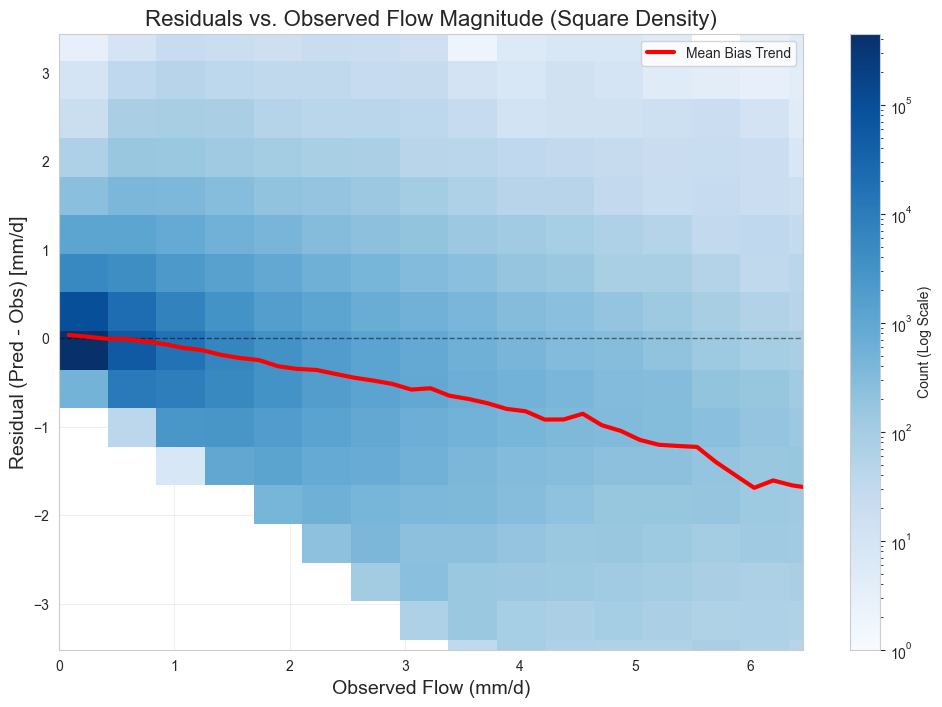

⚙️ Computing Volume Biases...


C:\Users\tbwil\AppData\Local\Temp\ipykernel_29896\3932939299.py:116: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_resampled = df_stn.resample('M').agg(['sum', 'count'])
C:\Users\tbwil\AppData\Local\Temp\ipykernel_29896\3932939299.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])


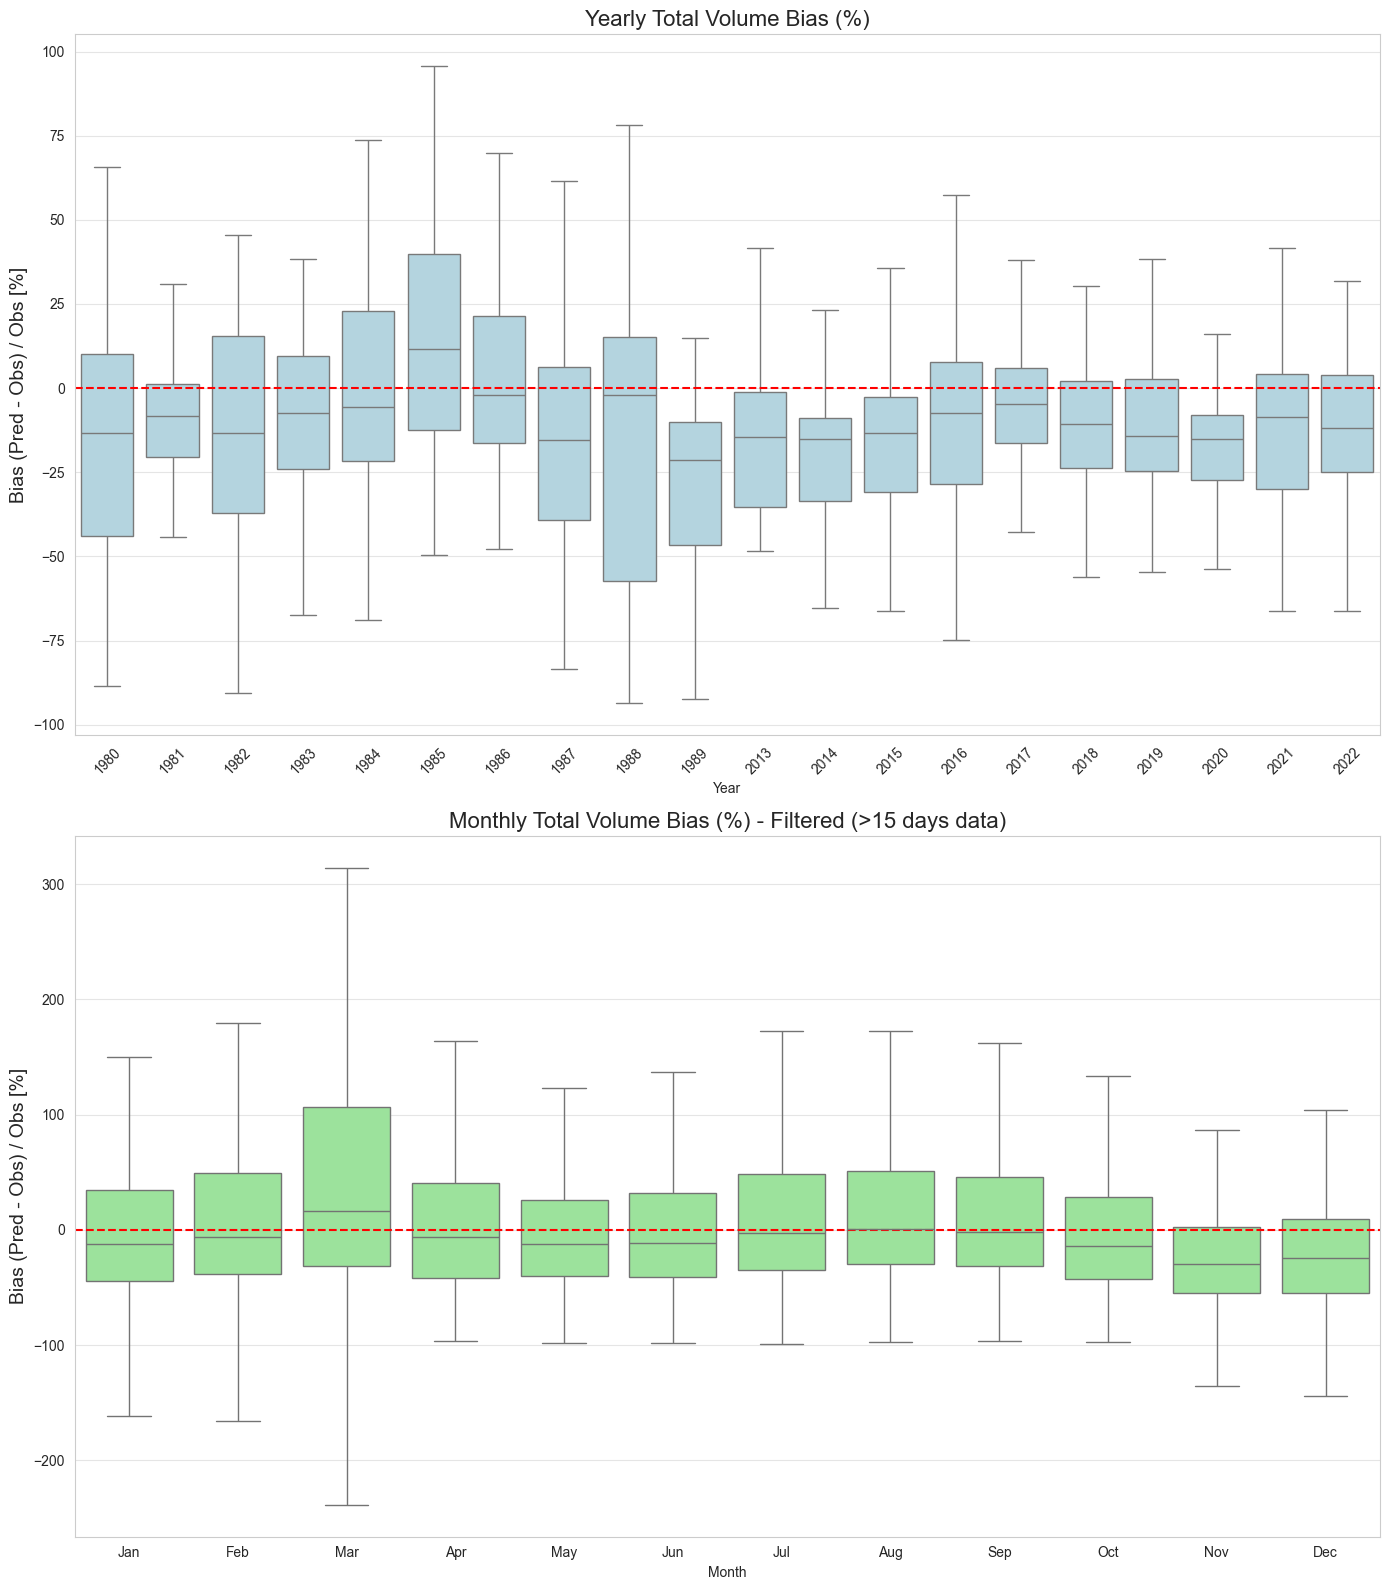


✅ Filtered Volume Analysis Complete.
   Monthly data points remaining after filtering: 21254
⚙️ Mapping Clusters to Volume Bias...


C:\Users\tbwil\AppData\Local\Temp\ipykernel_29896\3932939299.py:212: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(month_labels, fontsize=12)


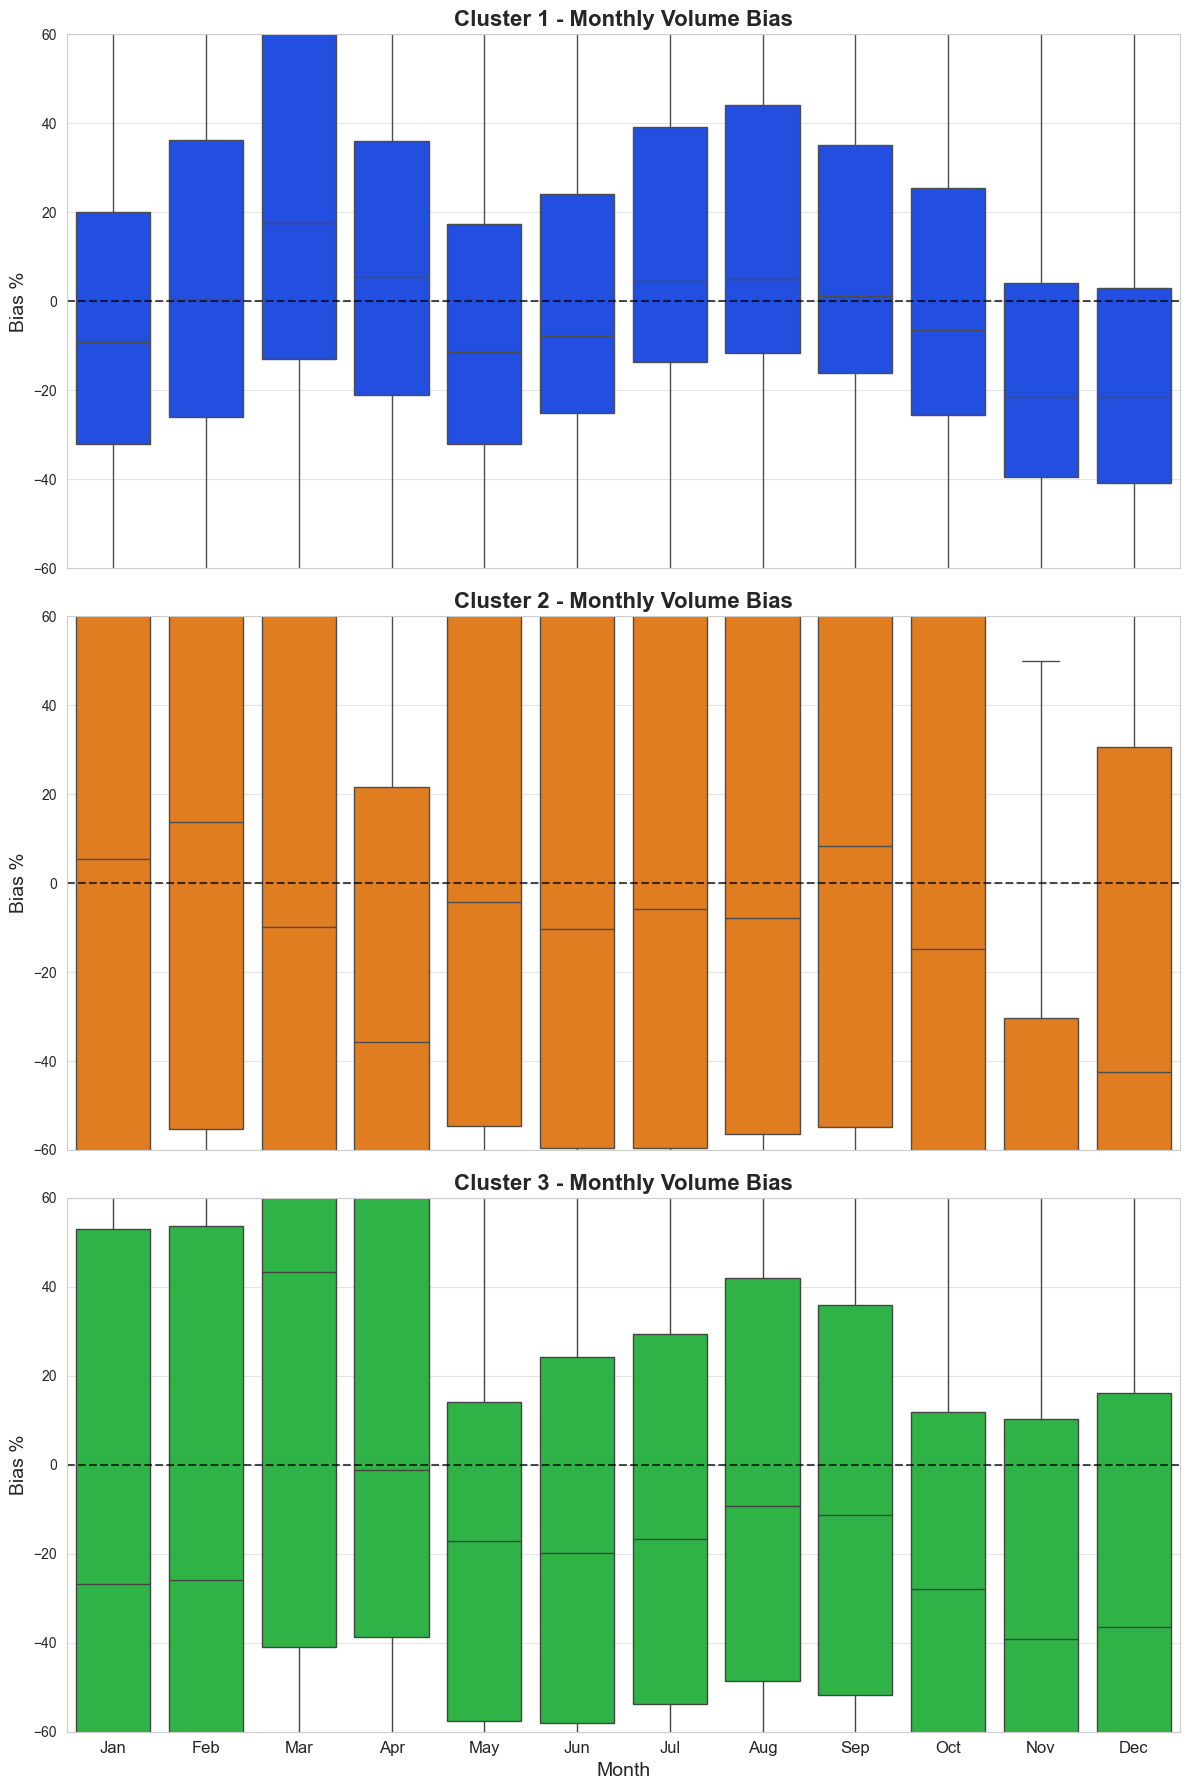


📊 Cluster Bias Diagnostics:

Cluster 1:
   Peak Over-Prediction: Mar (17.6%)
   Peak Under-Prediction: Nov (-21.6%)

Cluster 2:
   Peak Over-Prediction: Feb (13.8%)
   Peak Under-Prediction: Nov (-64.9%)

Cluster 3:
   Peak Over-Prediction: Mar (43.3%)
   Peak Under-Prediction: Nov (-39.1%)


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from src.config import PROCESSED_DATA_DIR, OUTPUT_DATA_DIR

# --- 1. Load Data ---
print("⏳ Loading Data...")
df_flow = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)
df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)
df_pred = pd.read_csv(OUTPUT_DATA_DIR / "test_set_predictions.csv", index_col=0, parse_dates=True)

# Align Data
common_cols = df_flow.columns.intersection(df_pred.columns).intersection(df_static.index)
common_idx = df_flow.index.intersection(df_pred.index)

df_obs = df_flow.loc[common_idx, common_cols]
df_pred = df_pred.loc[common_idx, common_cols]
df_static = df_static.loc[common_cols]

# Convert Obs to mm/d
areas = df_static['basin_area_km2']
df_obs_mmd = (df_obs * 86.4) / areas

print(f"✅ Analyzing {len(common_cols)} stations over {len(common_idx)} days.")

# --- 2. Residuals vs Flow Analysis (Square Bins) ---
print("⚙️ Computing Residuals...")

obs_flat = df_obs_mmd.values.flatten()
pred_flat = df_pred.values.flatten()

# Filter NaNs
mask = np.isfinite(obs_flat) & np.isfinite(pred_flat)
y_obs = obs_flat[mask]
y_pred = pred_flat[mask]
residuals = y_pred - y_obs

plt.figure(figsize=(12, 8))

# PLOT: Square Bins (hist2d)
# bins=150 gives much finer resolution
# cmin=1 makes empty bins transparent (white)
# cmap='Blues' makes higher density darker blue
# norm=LogNorm() allows seeing low-density outliers without them disappearing
counts, xedges, yedges, im = plt.hist2d(
    y_obs, residuals, 
    bins=400, 
    cmap='Blues', 
    cmin=1, 
    norm=LogNorm()
)

# Reference Line (0 Residual)
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Trendline (Cyan)
bins_x = np.linspace(0, np.percentile(y_obs, 99.5), 50)
bin_means = []
bin_centers = []

for i in range(len(bins_x)-1):
    mask_bin = (y_obs >= bins_x[i]) & (y_obs < bins_x[i+1])
    if np.sum(mask_bin) > 50: # Threshold to ensure stable mean
        bin_means.append(np.mean(residuals[mask_bin]))
        bin_centers.append((bins_x[i] + bins_x[i+1]) / 2)

plt.plot(bin_centers, bin_means, 'red', linewidth=3, label='Mean Bias Trend')
plt.colorbar(im, label='Count (Log Scale)')

plt.xlabel("Observed Flow (mm/d)", fontsize=14)
plt.ylabel("Residual (Pred - Obs) [mm/d]", fontsize=14)
plt.title("Residuals vs. Observed Flow Magnitude (Square Density)", fontsize=16)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Zoom to reasonable range
plt.xlim(0, np.percentile(y_obs, 99))
plt.ylim(np.percentile(residuals, 0.5), np.percentile(residuals, 99.95))
plt.show()

# --- 3. Volume Bias Analysis (With Monthly Filtering) ---
print("⚙️ Computing Volume Biases...")

vol_diff_yearly = [] 
vol_diff_monthly = []

for station in common_cols:
    df_stn = pd.concat([df_obs_mmd[station], df_pred[station]], axis=1, join='inner')
    df_stn.columns = ["obs", "pred"]
    
    # A. Yearly Volume
    # Group by Year: Get Sum AND Count
    yr_grouped = df_stn.groupby(df_stn.index.year)
    yr_sums = yr_grouped.sum()
    yr_counts = yr_grouped.count()
    
    # Filter: Keep years with > 300 valid days
    valid_years = yr_counts[yr_counts["obs"] > 300].index
    
    # Calculate Bias for valid years
    yr_bias = (yr_sums.loc[valid_years, "pred"] - yr_sums.loc[valid_years, "obs"])
    yr_pct = (yr_bias / yr_sums.loc[valid_years, "obs"]) * 100
    
    for yr in yr_pct.index:
        vol_diff_yearly.append({
            "Station": station,
            "Year": yr,
            "Bias_Pct": yr_pct.loc[yr]
        })

    # B. Monthly Volume (WITH NEW FILTER)
    # Resample to Monthly frequency first to get individual months (e.g., Jan 1980, Feb 1980)
    # This is critical. If we just groupby month (1-12), we lose the ability to filter specific bad months.
    monthly_resampled = df_stn.resample('M').agg(['sum', 'count'])
    
    # Structure after agg is MultiIndex columns: ('obs', 'sum'), ('obs', 'count')...
    
    # Filter: Keep individual months with >= 15 days of data
    valid_months = monthly_resampled[monthly_resampled[('obs', 'count')] >= 15]
    
    # Calculate Bias for each specific month-year (e.g. Bias for Jan 1980)
    m_bias = valid_months[('pred', 'sum')] - valid_months[('obs', 'sum')]
    m_pct = (m_bias / valid_months[('obs', 'sum')]) * 100
    
    # Now aggregate these back into seasonal bins (1=Jan, 2=Feb) for plotting
    # We iterate through the results
    for date, pct_val in m_pct.items():
        if np.isfinite(pct_val) and abs(pct_val) < 500: # Sanity check for massive outliers
            vol_diff_monthly.append({
                "Station": station,
                "Month": date.month,
                "Bias_Pct": pct_val
            })

df_vol_yr = pd.DataFrame(vol_diff_yearly)
df_vol_mo = pd.DataFrame(vol_diff_monthly)

# --- PLOT 2: Volume Bias Visualization ---
fig, axes = plt.subplots(2, 1, figsize=(14, 16))

# A. Yearly Bias
sns.boxplot(data=df_vol_yr, x="Year", y="Bias_Pct", ax=axes[0], color="lightblue", showfliers=False)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title("Yearly Total Volume Bias (%)", fontsize=16)
axes[0].set_ylabel("Bias (Pred - Obs) / Obs [%]", fontsize=14)
axes[0].grid(True, axis='y', alpha=0.5)
axes[0].tick_params(axis='x', rotation=45)

# B. Monthly Bias (Filtered)
sns.boxplot(data=df_vol_mo, x="Month", y="Bias_Pct", ax=axes[1], color="lightgreen", showfliers=False)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].set_title("Monthly Total Volume Bias (%) - Filtered (>15 days data)", fontsize=16)
axes[1].set_ylabel("Bias (Pred - Obs) / Obs [%]", fontsize=14)
axes[1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
axes[1].grid(True, axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"\n✅ Filtered Volume Analysis Complete.")
print(f"   Monthly data points remaining after filtering: {len(df_vol_mo)}")

# --- 4. Cluster-Based Monthly Bias Analysis ---
print("⚙️ Mapping Clusters to Volume Bias...")

# 1. Re-Calculate Clusters (Ensure we have the map available in this notebook)
# (Copying logic from previous steps to make this cell standalone-safe)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Compute Regime Curves
areas = df_static['basin_area_km2']
df_spec = (df_flow * 86.4) / areas
df_spec['doy'] = df_spec.index.dayofyear
regimes = df_spec.groupby('doy').mean().T
for stn in regimes.index:
    regimes.loc[stn] = regimes.loc[stn].fillna(regimes.loc[stn].min())

scaler = StandardScaler()
regimes_norm = scaler.fit_transform(regimes.T).T 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(regimes_norm)
cluster_map = pd.Series(labels, index=regimes.index, name="Cluster")

# 2. Map Clusters to the Volume DataFrame
df_vol_mo['Cluster'] = df_vol_mo['Station'].map(cluster_map)

# 3. Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
colors = sns.color_palette("bright", 3)
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for k in range(3):
    ax = axes[k]
    subset = df_vol_mo[df_vol_mo["Cluster"] == k]
    
    # Boxplot
    sns.boxplot(data=subset, x="Month", y="Bias_Pct", ax=ax, color=colors[k], showfliers=False)
    
    # Reference Line
    ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Formatting
    ax.set_title(f"Cluster {k+1} - Monthly Volume Bias", fontsize=16, weight='bold')
    ax.set_ylabel("Bias %", fontsize=14)
    ax.set_ylim(-60, 60) # consistent y-limits help comparison
    ax.grid(True, axis='y', alpha=0.5)

# Set x-labels only on bottom plot
axes[2].set_xticklabels(month_labels, fontsize=12)
axes[2].set_xlabel("Month", fontsize=14)

plt.tight_layout()
plt.show()

# --- Print Interpretation Stats ---
print("\n📊 Cluster Bias Diagnostics:")
for k in range(3):
    subset = df_vol_mo[df_vol_mo["Cluster"] == k]
    median_bias = subset.groupby("Month")["Bias_Pct"].median()
    
    print(f"\nCluster {k+1}:")
    print(f"   Peak Over-Prediction: {month_labels[median_bias.idxmax()-1]} ({median_bias.max():.1f}%)")
    print(f"   Peak Under-Prediction: {month_labels[median_bias.idxmin()-1]} ({median_bias.min():.1f}%)")